In [2]:
import pandas as pd
import numpy as np
import missingno as mo

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rule
from sklearn.linear_model import LogisticRegression as Logit

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

#plotting
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sn

# permutation
from sklearn.inspection import permutation_importance

## Load the Data

In [3]:
jordan = pd.read_csv("arabbaro/arabbaro_jo_labeled_reduced.csv")

In [4]:
jordan

,Unnamed: 0,income,in_capital,married,employed,employed_pub_sec,employed_priv_sec,selfemp,retired,housewife,...,infs_television,infs_socmed,country_of_origin_jordan,y_dem_top_issue,y_dem_pref,y_2_dem_pref_not_in_dem,y_1_distrust_gov,y_distrust_army,y_distrust_pres_prime,y_trust_ikhwan
0,1,500,True,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
1,2,200,True,True,False,False,False,False,False,True,...,False,True,False,False,True,False,True,False,False,False
2,3,850,True,True,False,False,False,False,False,True,...,False,False,False,False,True,True,True,False,False,False
3,4,200,False,True,True,False,True,False,False,False,...,False,True,True,False,False,False,True,False,False,False
4,5,650,False,True,False,False,False,True,False,False,...,False,True,False,False,True,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2358,2359,300,False,True,False,False,False,False,False,True,...,False,True,True,False,True,False,True,False,False,False
2359,2360,999,False,True,False,False,False,False,False,True,...,False,True,True,False,True,False,True,False,False,False
2360,2361,0,False,True,False,False,False,False,True,False,...,True,False,True,False,True,True,True,False,False,False
2361,2362,650,False,True,False,False,False,False,False,True,...,True,False,False,False,True,True,True,False,False,False


In [5]:
jordan.drop(columns = ["y_dem_top_issue", "y_dem_pref", "y_distrust_army", "y_distrust_pres_prime", "y_trust_ikhwan", "Unnamed: 0"],inplace = True)

In [6]:
kuwait = pd.read_csv("arabbaro/arabbaro_kuw_labeled_reduced.csv")

In [7]:
kuwait.drop(columns = ["y_dem_top_issue", "y_dem_pref", "y_distrust_army", "y_distrust_pres_prime", "y_trust_ikhwan", "Unnamed: 0"], inplace = True)

In [8]:
egypt = pd.read_csv("arabbaro/arabbaro_egy_labeled_reduced.csv")

In [9]:
egypt.drop(columns = ["y_dem_top_issue", "y_dem_pref", "y_distrust_army", "y_distrust_pres_prime", "y_trust_ikhwan", "Unnamed: 0"], inplace = True)

In [10]:
morocco = pd.read_csv("arabbaro/arabbaro_mor_labeled_reduced.csv")

In [11]:
morocco.drop(columns = ["y_dem_top_issue", "y_dem_pref", "y_distrust_army", "y_distrust_pres_prime", "y_trust_ikhwan", "Unnamed: 0"], inplace = True)

In [12]:
algeria = pd.read_csv("arabbaro/arabbaro_alg_labeled_reduced.csv")

In [13]:
algeria.drop(columns = ["y_dem_top_issue", "y_dem_pref", "y_distrust_army", "y_distrust_pres_prime", "y_trust_ikhwan", "Unnamed: 0"],inplace = True)

## Functions Containing the Model and Related Metrics

In [14]:
def dempref(df):
    # set up SKLearn Framework
    y = df.y_2_dem_pref_not_in_dem
    if 'y_1_distrust_gov' in df.columns:
        X = df.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_distrust_gov"])
    else:  
        X = df.drop(columns = "y_2_dem_pref_not_in_dem")

    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

    # Set the folds index to ensure comparable samples
    fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

    # Build the modeling pipeline
    pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

    search_space = [
    
        # NaiveBayes
        {'model': [NB()]},
    
        # KNN with K tuning param
        {'model' : [KNN()],
        'model__n_neighbors':[5,10,25,50]},
    
        # Decision Tree with the Max Depth Param
        {'model': [DT()],
        'model__max_depth':[2,3,4]},
    
        # Random forest with the N Estimators, max depth, and max features tuning param
        {'model' : [RF()],
        'model__max_depth':[6,7,8],
        'model__n_estimators':[500,1000,1500],
        'model__max_features': [5,10,15]},
        
        # logit model
        {'model': [Logit()],
        'model__class_weight':[None, "balanced"]},
    
    ]

    # Grid Search to find the best parameters. The metric used for evaluation is ROC AUC
    search = GridSearchCV(pipe, search_space, 
                         cv = fold_generator,
                         scoring='roc_auc',
                         n_jobs=1)

    # fit the data with the model
    search.fit(train_X,train_y)
    
    best_mod = search.best_estimator_

    return(search.best_score_, search.best_estimator_, search.predict(test_X), m.plot_confusion_matrix(best_mod, test_X, test_y), train_X, test_X, train_y, test_y)

In [15]:
def trustgov(df):
    # set up SKLearn Framework
    y = df.y_1_distrust_gov
    if 'y_2_dem_pref_not_in_dem' in df.columns:
        X = df.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_distrust_gov"])
    else:  
        X = df.drop(columns = "y_1_distrust_gov")
    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

    # Set the folds index to ensure comparable samples
    fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

    # Build the modeling pipeline
    pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

    search_space = [
    
        # NaiveBayes
        {'model': [NB()]},
    
        # KNN with K tuning param
        {'model' : [KNN()],
        'model__n_neighbors':[5,10,25,50]},
    
        # Decision Tree with the Max Depth Param
        {'model': [DT()],
        'model__max_depth':[2,3,4]},
    
        # Random forest with the N Estimators, max depth, and max features tuning param
        {'model' : [RF()],
        'model__max_depth':[6,7,8],
        'model__n_estimators':[500,1000,1500],
        'model__max_features': [5,10,15]},
        
        # logit model
        {'model': [Logit()],
        'model__class_weight':[None, "balanced"]},
    
    ]

    # Grid Search to find the best parameters. The metric used for evaluation is ROC AUC
    search = GridSearchCV(pipe, search_space, 
                         cv = fold_generator,
                         scoring='roc_auc',
                         n_jobs=1)

    # fit the data with the model
    search.fit(train_X,train_y)
    
    best_mod = search.best_estimator_

    return(search.best_score_, search.best_estimator_, search.predict(test_X), m.plot_confusion_matrix(best_mod, test_X, test_y), train_X, test_X, train_y, test_y)

## Run the Functions on the Data from Each Country

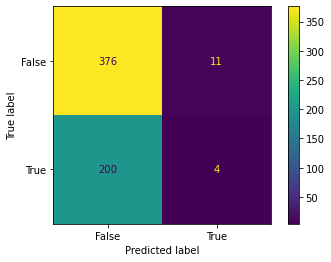

In [16]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = dempref(jordan)

In [19]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, best_mod.predict(test_X)))

In [23]:
confusion_matrix.to_csv("Confusion_Matrices/Jordan_DemPref_RF.csv")

In [59]:
score

0.5689980329992693

In [60]:
clf = RF(max_depth=6, max_features=5, n_estimators=500)

In [61]:
clf.fit(train_X,train_y)

RandomForestClassifier(max_depth=6, max_features=5, n_estimators=500)

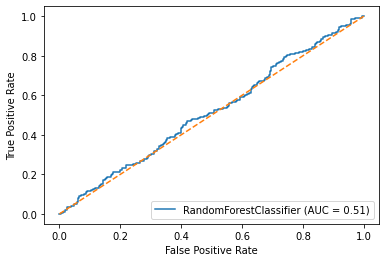

In [62]:
m.plot_roc_curve(clf, test_X, test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.show()

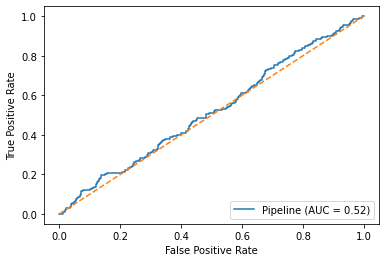

In [63]:
m.plot_roc_curve(best_mod,test_X,test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

In [64]:
fig=plt.figure()
fig.show()

<Figure size 432x288 with 0 Axes>

In [65]:
print("hello world")

hello world


In [66]:
# Set the the first threshold as 0.8
threshold1 = 0.75

In [67]:
# Set the the first threshold as 0.8
threshold2 = 0.25

In [68]:
# use predict probabilities function
# First predictive threshold: 1 when greater than 80% probability
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [69]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

In [ ]:
confusion_matrix_1.to_csv("Confusion_Matrices/Jordan_DemPref_RF_threshold_0.75.csv")

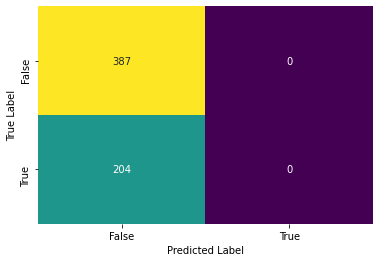

In [70]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [71]:
# Second predictive threshold: 0 when greater than 20% probability
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [72]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

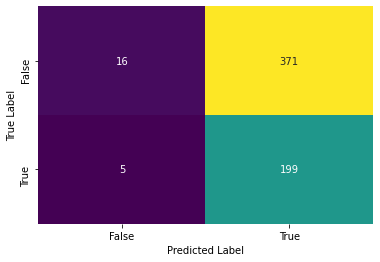

In [73]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
confusion_matrix_2.to_csv("Confusion_Matrices/Jordan_DemPref_RF_threshold_0.25.csv")

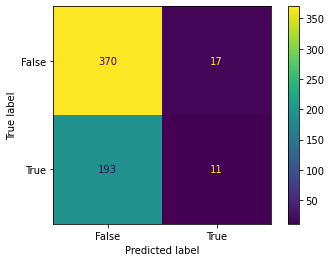

In [74]:
confusion.figure_

In [75]:
# show which model worked best
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=6, max_features=10,
                                        n_estimators=500))])

In [76]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [77]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,age,0.040745,0.001763,3.721885e-02,0.044271
1,educ,0.020655,0.002732,1.519019e-02,0.026119
2,income,0.020429,0.002212,1.600544e-02,0.024852
3,unemp,0.014221,0.002183,9.855738e-03,0.018587
4,male,0.013770,0.001454,1.086138e-02,0.016678
5,neighb_rich,0.013770,0.000451,1.286682e-02,0.014673
6,internet_use_bin,0.011964,0.001902,8.159752e-03,0.015768
7,housewife,0.009707,0.001868,5.969990e-03,0.013443
8,neighb_mixed,0.008916,0.000422,8.071861e-03,0.009761
9,infs_socmed,0.007111,0.002488,2.134219e-03,0.012087


In [78]:
vi_dat.to_csv("variable importance csv/jordan_y2")

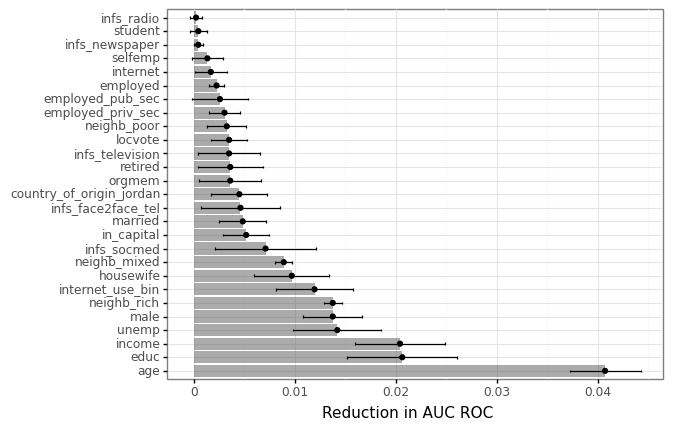

<ggplot: (8772554876669)>

In [79]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

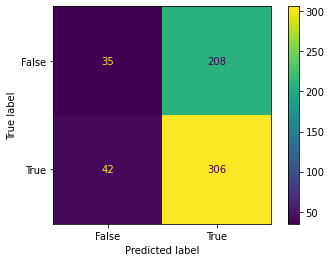

In [80]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = trustgov(jordan)

In [ ]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, best_mod.predict(test_X)))

In [ ]:
confusion_matrix.to_csv("Confusion_Matrices/Jordan_TrustGov_RF.csv")

In [81]:
score

0.5766221651194685

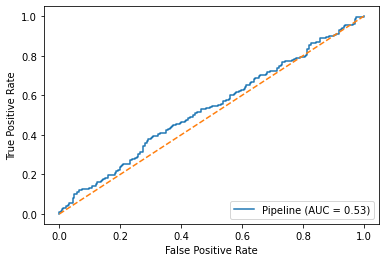

In [82]:
m.plot_roc_curve(best_mod,test_X,test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

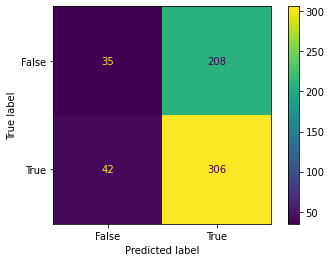

In [83]:
confusion.figure_

In [84]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [85]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

In [ ]:
confusion_matrix_1.to_csv("Confusion_Matrices/Jordan_TrustGov_RF_threshold_0.75.csv")

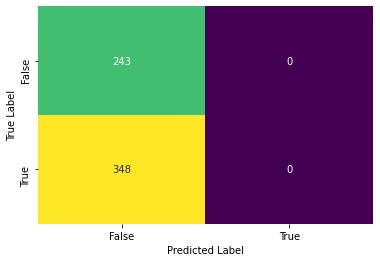

In [86]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [87]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [88]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

In [ ]:
confusion_matrix_2.to_csv("Confusion_Matrices/Jordan_TrustGov_RF_threshold_0.25.csv")

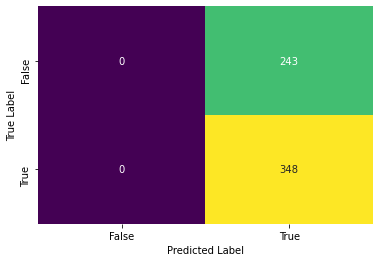

In [89]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [90]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=6, max_features=5,
                                        n_estimators=500))])

In [91]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [92]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,educ,0.029345,0.004101,0.021144,0.037547
1,age,0.026975,0.003099,0.020777,0.033174
2,income,0.021332,0.003884,0.013564,0.029099
3,infs_socmed,0.016140,0.003787,0.008565,0.023715
4,male,0.015463,0.003321,0.008820,0.022106
5,internet_use_bin,0.014221,0.003412,0.007397,0.021046
6,housewife,0.010722,0.004775,0.001172,0.020273
7,country_of_origin_jordan,0.010158,0.001712,0.006735,0.013581
8,neighb_mixed,0.009932,0.000917,0.008098,0.011766
9,retired,0.009368,0.003164,0.003039,0.015697


In [93]:
vi_dat.to_csv("variable importance csv/jordan_y1")

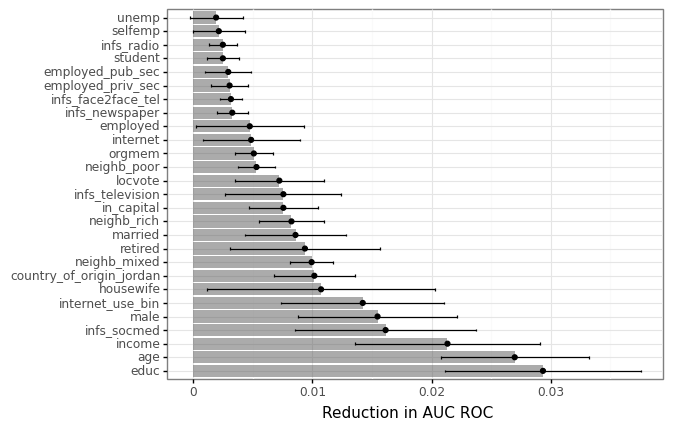

<ggplot: (8772576544793)>

In [94]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

In [95]:
kuwait.isna().sum()

below_medinc             0
above_medinc             0
in_capital               0
married                  0
employed                 0
employed_pub_sec         0
employed_priv_sec        0
selfemp                  0
retired                  0
housewife                0
student                  0
unemp                    0
neighb_rich           1304
neighb_poor           1304
neighb_mixed          1304
educ                     0
male                     0
age                      0
orgmem                   0
charity                  0
campaign_attend          0
locvote                  0
internet                 0
internet_use_bin         0
infs_face2face_tel       0
infs_newspaper           0
infs_radio               0
infs_television          0
infs_socmed              0
y_1_distrust_gov         0
dtype: int64

In [96]:
kuwait.drop(columns = ["neighb_rich", "neighb_poor", "neighb_mixed"], inplace = True)

In [97]:
kuwait

,below_medinc,above_medinc,in_capital,married,employed,employed_pub_sec,employed_priv_sec,selfemp,retired,housewife,...,campaign_attend,locvote,internet,internet_use_bin,infs_face2face_tel,infs_newspaper,infs_radio,infs_television,infs_socmed,y_1_distrust_gov
0,False,False,False,True,True,True,False,False,False,False,...,False,False,True,1.0,False,False,False,False,True,True
1,False,True,False,True,True,True,False,False,False,False,...,True,True,True,1.0,False,False,False,False,True,False
2,False,False,False,True,False,False,False,False,True,False,...,False,False,True,0.8,False,False,False,False,True,True
3,True,False,False,True,False,False,False,False,True,False,...,True,True,True,1.0,False,False,False,False,True,True
4,True,False,False,True,True,True,False,False,False,False,...,False,False,True,1.0,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,False,False,False,False,False,False,False,False,False,False,...,False,False,True,1.0,False,False,False,False,True,False
1300,False,True,False,True,True,False,True,False,False,False,...,False,False,True,1.0,False,False,False,False,True,False
1301,False,False,False,True,True,False,True,False,False,False,...,False,False,True,1.0,False,False,False,False,True,False
1302,False,False,False,False,False,False,False,False,False,False,...,False,False,True,1.0,False,False,False,False,True,False


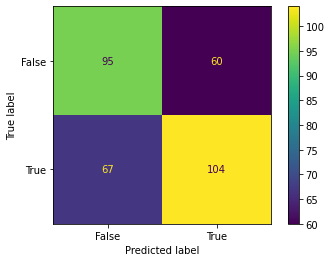

In [98]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = trustgov(kuwait)

In [ ]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, best_mod.predict(test_X)))

In [ ]:
confusion_matrix.to_csv("Confusion_Matrices/Kuwait_TrustGov_RF.csv")

In [99]:
score

0.652575695512045

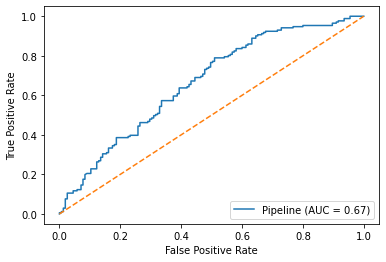

In [100]:
m.plot_roc_curve(best_mod,test_X,test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

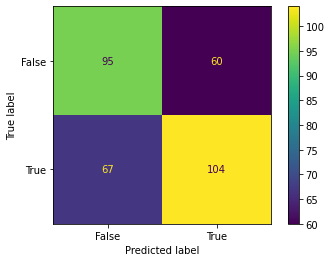

In [101]:
confusion.figure_

In [102]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=6, max_features=5,
                                        n_estimators=1000))])

In [103]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [104]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

In [ ]:
confusion_matrix_1.to_csv("Confusion_Matrices/Kuwait_TrustGov_RF_threshold_0.75.csv")

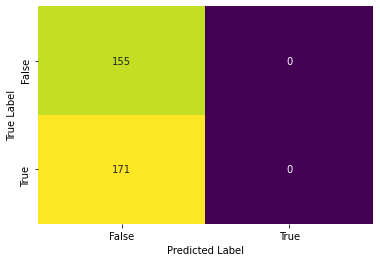

In [105]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [106]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [107]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

In [ ]:
confusion_matrix_2.to_csv("Confusion_Matrices/Kuwait_TrustGov_RF_threshold_0.25.csv")

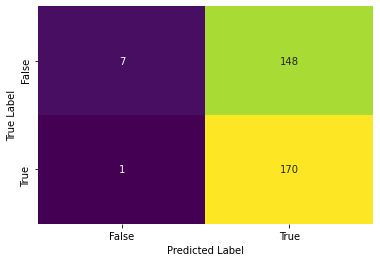

In [108]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [109]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [110]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,infs_socmed,0.057055,0.009858,0.037338,0.076772
1,age,0.049898,0.009666,0.030566,0.069229
2,above_medinc,0.030470,0.003955,0.022561,0.038380
3,charity,0.026380,0.002698,0.020985,0.031775
4,retired,0.022086,0.003458,0.015169,0.029003
5,educ,0.018200,0.002454,0.013292,0.023108
6,locvote,0.016155,0.004110,0.007935,0.024376
7,married,0.015746,0.001661,0.012424,0.019069
8,male,0.014519,0.003446,0.007627,0.021412
9,orgmem,0.010838,0.003006,0.004827,0.016849


In [111]:
vi_dat.to_csv("variable importance csv/kuwait_y1")

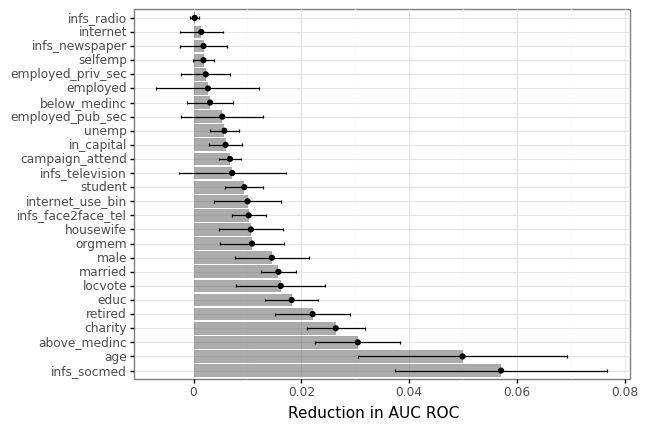

<ggplot: (8772576654749)>

In [112]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

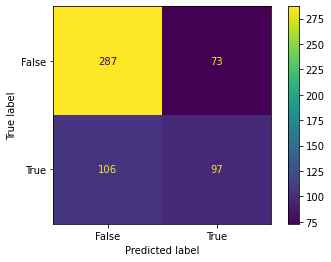

In [113]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = dempref(morocco)

In [ ]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, best_mod.predict(test_X)))

In [ ]:
confusion_matrix.to_csv("Confusion_Matrices/Morocco_DemPref_RF.csv")

In [114]:
score

0.7197685322380083

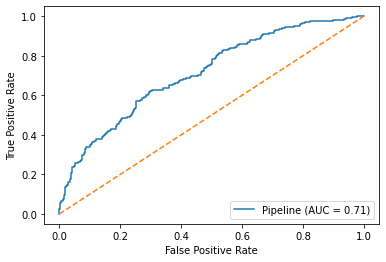

In [115]:
m.plot_roc_curve(best_mod,test_X,test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

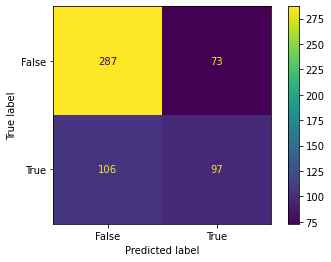

In [116]:
confusion.figure_

In [117]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=6, max_features=5,
                                        n_estimators=1000))])

In [118]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [119]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

In [ ]:
confusion_matrix_1.to_csv("Confusion_Matrices/Morocco_DemPref_threshold_0.75.csv")

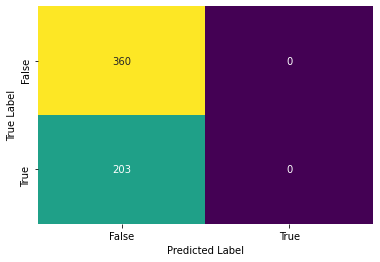

In [120]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [121]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [122]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

In [ ]:
confusion_matrix_1.to_csv("Confusion_Matrices/Morocco_DemPref_threshold_0.25.csv")

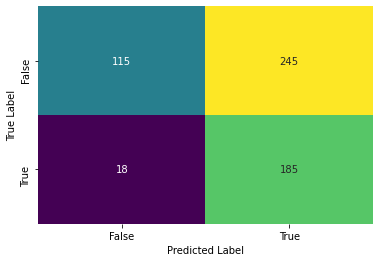

In [123]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [124]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [125]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,educ,0.034282,0.005669,0.022944,0.045621
1,age,0.024555,0.005379,0.013798,0.035313
2,internet_use_bin,0.023013,0.006123,0.010768,0.035258
3,male,0.011744,0.002637,0.006471,0.017017
4,internet,0.010676,0.004920,0.000837,0.020516
5,orgmem,0.009727,0.001618,0.006492,0.012963
6,student,0.008185,0.001020,0.006144,0.010226
7,infs_socmed,0.007948,0.003610,0.000728,0.015167
8,infs_television,0.006287,0.003038,0.000211,0.012364
9,unemp,0.005931,0.002431,0.001069,0.010793


In [126]:
vi_dat.to_csv("variable importance csv/morocco_y2")

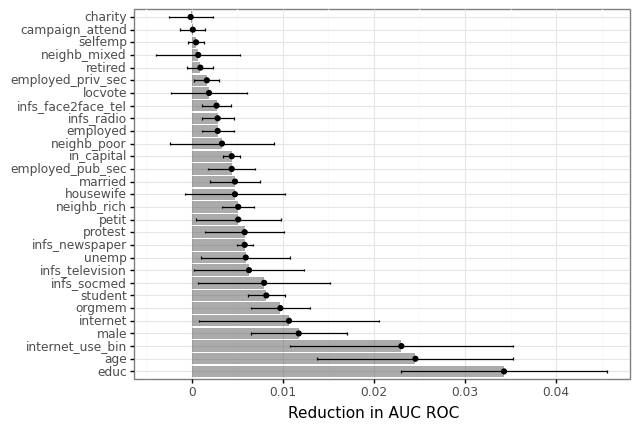

<ggplot: (8772576575841)>

In [127]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

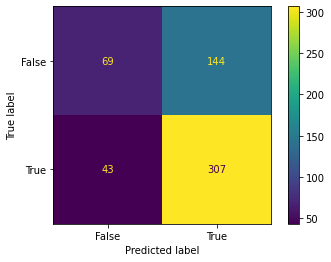

In [128]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = trustgov(morocco)

In [ ]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, best_mod.predict(test_X)))

In [ ]:
confusion_matrix.to_csv("Confusion_Matrices/Morocco_TrustGov_RF.csv")

In [129]:
score

0.739518707368038

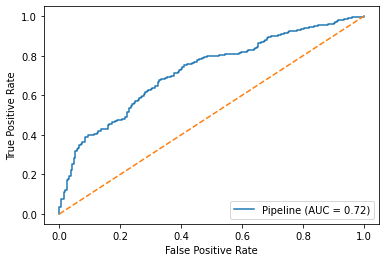

In [130]:
m.plot_roc_curve(best_mod,test_X,test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

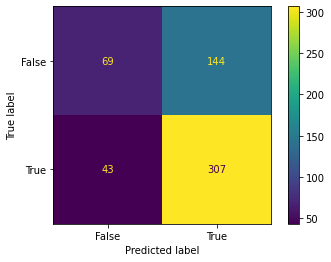

In [131]:
confusion.figure_

In [132]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=7, max_features=5,
                                        n_estimators=500))])

In [133]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [134]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

In [ ]:
confusion_matrix_1.to_csv("Confusion_Matrices/Morocco_TrustGov_threshold_0.75.csv")

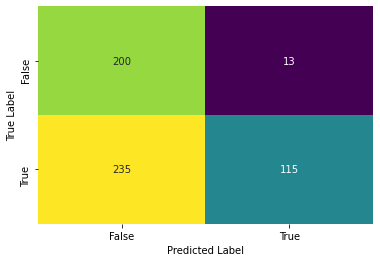

In [135]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [136]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [137]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

In [ ]:
confusion_matrix_2.to_csv("Confusion_Matrices/Morocco_TrustGov_threshold_0.25.csv")

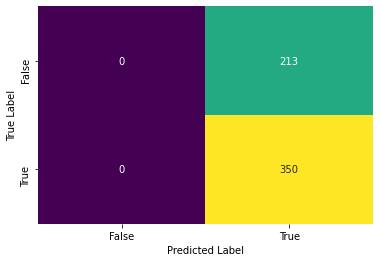

In [138]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [139]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [140]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,age,0.076512,0.004058,6.839733e-02,0.084628
1,locvote,0.048280,0.003174,4.193163e-02,0.054628
2,educ,0.025979,0.004012,1.795419e-02,0.034003
3,protest,0.020047,0.005864,8.318665e-03,0.031776
4,campaign_attend,0.018980,0.002122,1.473581e-02,0.023224
5,internet_use_bin,0.016133,0.002689,1.075408e-02,0.021512
6,infs_television,0.016014,0.001061,1.389222e-02,0.018136
7,infs_socmed,0.013286,0.003744,5.798466e-03,0.020773
8,charity,0.012574,0.001853,8.868209e-03,0.016280
9,neighb_poor,0.010202,0.001519,7.163405e-03,0.013240


In [141]:
vi_dat.to_csv("variable importance csv/morocco_y1")

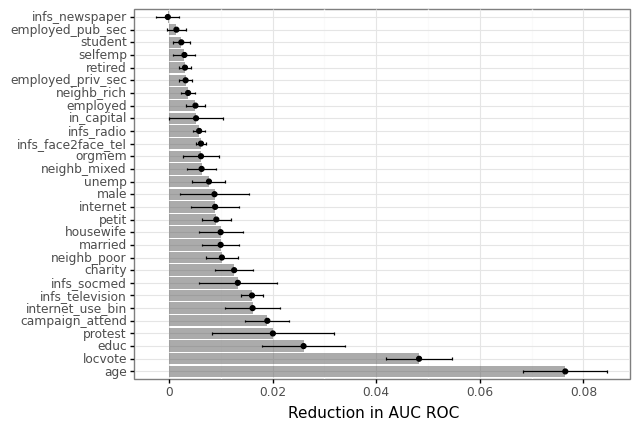

<ggplot: (8772576787194)>

In [142]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

In [143]:
egypt.drop(columns = "locvote", inplace = True)

In [144]:
egypt.dropna(inplace = True)

In [145]:
egypt.isna().sum()

income                     0
in_capital                 0
married                    0
employed                   0
employed_pub_sec           0
employed_priv_sec          0
selfemp                    0
retired                    0
housewife                  0
student                    0
unemp                      0
neighb_rich                0
neighb_poor                0
neighb_mixed               0
educ                       0
male                       0
age                        0
orgmem                     0
charity                    0
petit                      0
protest                    0
campaign_attend            0
internet                   0
internet_use_bin           0
infs_face2face_tel         0
infs_newspaper             0
infs_radio                 0
infs_television            0
infs_socmed                0
y_2_dem_pref_not_in_dem    0
y_1_distrust_gov           0
dtype: int64

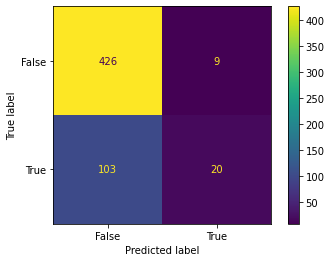

In [146]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = dempref(egypt)

In [ ]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, best_mod.predict(test_X)))

In [ ]:
confusion_matrix.to_csv("Confusion_Matrices/Egypt_DemPref_RF.csv")

In [147]:
score

0.7496033307409744

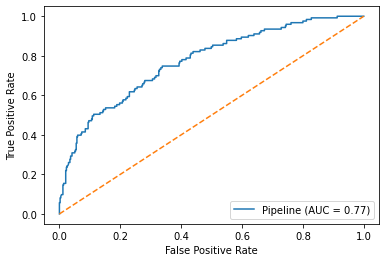

In [148]:
m.plot_roc_curve(best_mod,test_X,test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

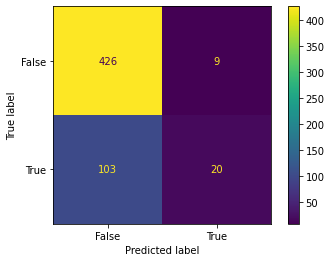

In [149]:
confusion.figure_

In [150]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=8, max_features=5,
                                        n_estimators=1500))])

In [151]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [152]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

In [ ]:
confusion_matrix_1.to_csv("Confusion_Matrices/Egypt_DemPref_threshold_0.75.csv")

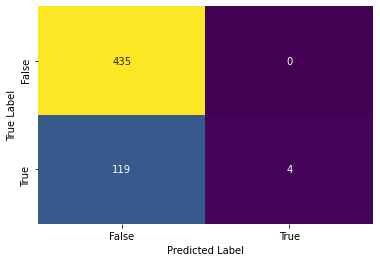

In [153]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [154]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [155]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

In [ ]:
confusion_matrix_2.to_csv("Confusion_Matrices/Egypt_DemPref_threshold_0.25.csv")

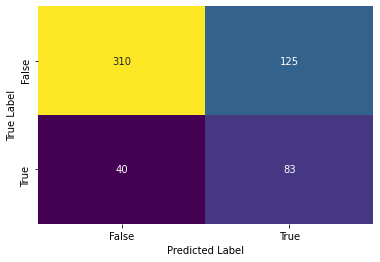

In [156]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [157]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [158]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,infs_socmed,0.026420,0.001159,0.024102,0.028738
1,protest,0.023431,0.003769,0.015893,0.030969
2,internet_use_bin,0.020801,0.001096,0.018610,0.022992
3,age,0.009564,0.001773,0.006017,0.013110
4,campaign_attend,0.007531,0.001757,0.004017,0.011045
5,income,0.007531,0.000811,0.005910,0.009153
6,educ,0.007292,0.001829,0.003635,0.010950
7,petit,0.007292,0.001749,0.003795,0.010790
8,orgmem,0.006934,0.000895,0.005144,0.008723
9,married,0.003945,0.001171,0.001602,0.006288


In [159]:
vi_dat.to_csv("variable importance csv/egypt_y2")

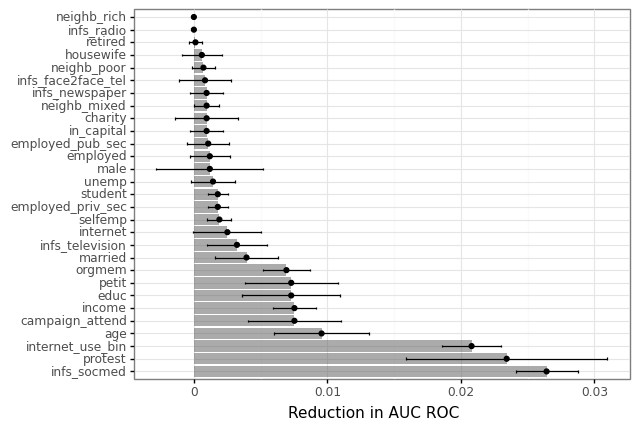

<ggplot: (8772554943377)>

In [160]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

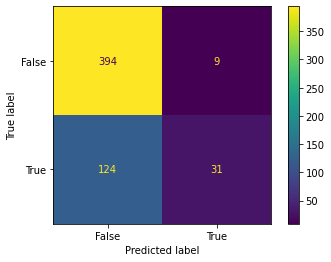

In [161]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = trustgov(egypt)

In [ ]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, best_mod.predict(test_X)))

In [ ]:
confusion_matrix.to_csv("Confusion_Matrices/Egypt_TrustGov_RF.csv")

In [162]:
score

0.7179231247669585

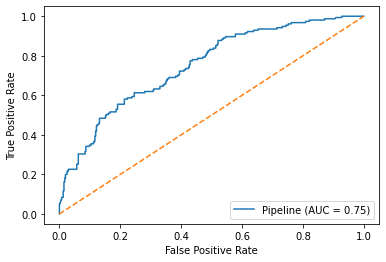

In [163]:
m.plot_roc_curve(best_mod,test_X,test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

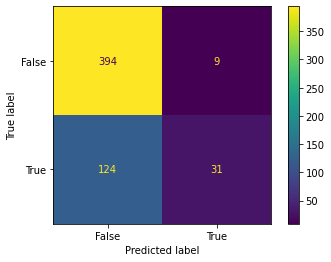

In [164]:
confusion.figure_

In [165]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=8, max_features=5,
                                        n_estimators=1500))])

In [166]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [167]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

In [ ]:
confusion_matrix_1.to_csv("Confusion_Matrices/Egypt_TrustGov_threshold_0.75.csv")

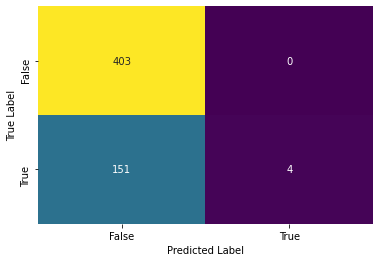

In [168]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [169]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [170]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

In [ ]:
confusion_matrix_2.to_csv("Confusion_Matrices/Egypt_TrustGov_threshold_0.25.csv")

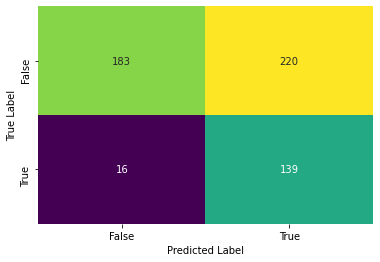

In [171]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [172]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [173]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,protest,0.044471,0.002256,0.039960,0.048982
1,age,0.035744,0.002462,0.030821,0.040667
2,unemp,0.023790,0.002432,0.018925,0.028654
3,income,0.021518,0.003024,0.015470,0.027567
4,infs_socmed,0.021279,0.001288,0.018704,0.023854
5,infs_television,0.020921,0.001852,0.017217,0.024624
6,charity,0.019127,0.001813,0.015501,0.022753
7,internet_use_bin,0.018649,0.003149,0.012351,0.024948
8,campaign_attend,0.012194,0.001042,0.010109,0.014278
9,educ,0.009922,0.001493,0.006936,0.012909


In [174]:
vi_dat.to_csv("variable importance csv/egypt_y1")

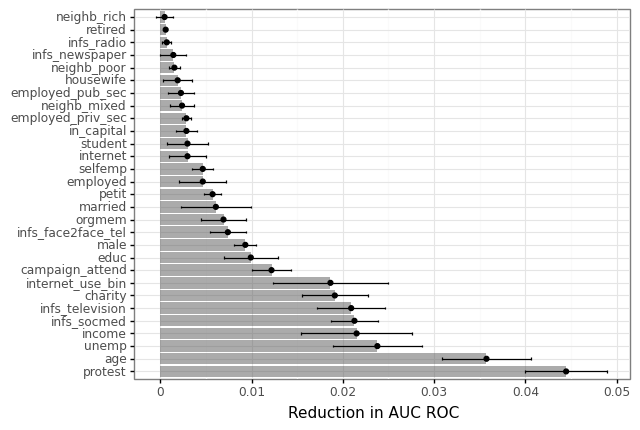

<ggplot: (8772554948057)>

In [175]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

In [176]:
algeria.dropna(inplace = True)

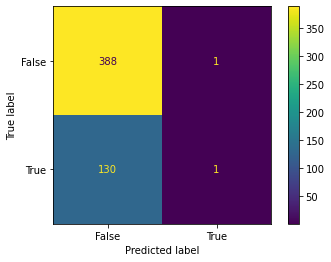

In [177]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = dempref(algeria)

In [ ]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, best_mod.predict(test_X)))

In [ ]:
confusion_matrix.to_csv("Confusion_Matrices/Algeria_DemPref_RF.csv")

In [178]:
score

0.6100110067586514

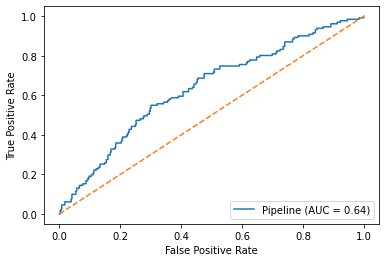

In [179]:
m.plot_roc_curve(best_mod,test_X,test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

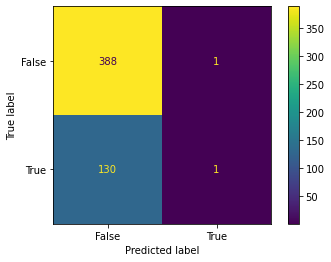

In [180]:
confusion.figure_

In [181]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=6, max_features=5,
                                        n_estimators=1500))])

In [182]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [183]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

In [ ]:
confusion_matrix_1.to_csv("Confusion_Matrices/Algeria_DemPref_threshold_0.75.csv")

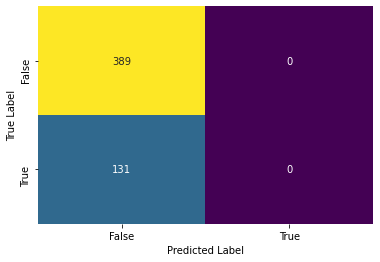

In [184]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [185]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [186]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

In [ ]:
confusion_matrix_2.to_csv("Confusion_Matrices/Algeria_DemPref_threshold_0.25.csv")

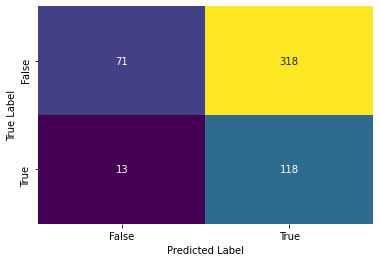

In [187]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [188]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [189]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,campaign_attend,0.004624,0.000629,3.365709e-03,0.005883
1,age,0.004496,0.001075,2.346410e-03,0.006645
2,locvote,0.003982,0.000257,3.468208e-03,0.004496
3,educ,0.003725,0.000749,2.227116e-03,0.005223
4,internet_use_bin,0.002826,0.001604,-3.827864e-04,0.006035
5,charity,0.002697,0.000749,1.199499e-03,0.004195
6,petit,0.002312,0.000315,1.682854e-03,0.002941
7,orgmem,0.002312,0.000655,1.002179e-03,0.003622
8,retired,0.002055,0.000481,1.093987e-03,0.003016
9,married,0.001927,0.001149,-3.710397e-04,0.004225


In [190]:
vi_dat.to_csv("variable importance csv/algeria_y2")

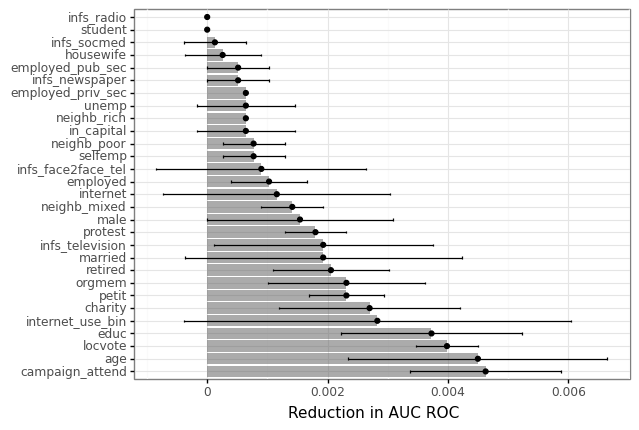

<ggplot: (8772606375313)>

In [191]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

## Logit Models

In [192]:
# train-test split
y = jordan.y_2_dem_pref_not_in_dem
X = jordan.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_distrust_gov"])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

In [193]:
LogitR = Logit(class_weight = 'balanced')

In [194]:
clf = LogitR.fit(train_X, train_y)

In [195]:
pred_y= clf.predict(test_X)

In [196]:
m.roc_auc_score(test_y, pred_y)

0.4907470740234078

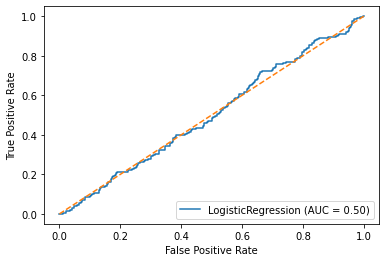

In [197]:
m.plot_roc_curve(LogitR, test_X, test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

In [ ]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, pred_y))

In [ ]:
confusion_matrix.to_csv("Confusion_Matrices/Jordan_DemPref_Logit.csv")

In [199]:
# train-test split
y = jordan.y_1_distrust_gov
X = jordan.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_distrust_gov"])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

In [200]:
clf = LogitR.fit(train_X, train_y)

In [201]:
pred_y= clf.predict(test_X)

In [202]:
m.roc_auc_score(test_y, pred_y)

0.5357421597843053

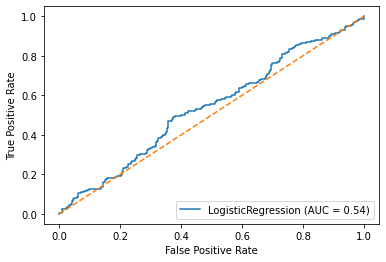

In [203]:
m.plot_roc_curve(LogitR, test_X, test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

In [ ]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, pred_y))

In [ ]:
confusion_matrix.to_csv("Confusion_Matrices/Jordan_TrustGov_Logit.csv")

In [205]:
# train-test split
y = kuwait.y_1_distrust_gov
X = kuwait.drop(columns = ["y_1_distrust_gov"])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

In [206]:
clf = LogitR.fit(train_X, train_y)

In [207]:
pred_y= clf.predict(test_X)

In [208]:
m.roc_auc_score(test_y, pred_y)

0.5

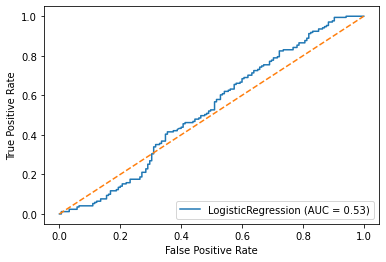

In [209]:
m.plot_roc_curve(LogitR, test_X, test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

In [ ]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, pred_y))

In [ ]:
confusion_matrix.to_csv("Confusion_Matrices/Kuwait_TrustGov_Logit.csv")

In [210]:
# train-test split
y = morocco.y_2_dem_pref_not_in_dem
X = morocco.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_distrust_gov"])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

In [211]:
clf = LogitR.fit(train_X, train_y)

In [212]:
pred_y= clf.predict(test_X)

In [213]:
m.roc_auc_score(test_y, pred_y)

0.6481800766283524

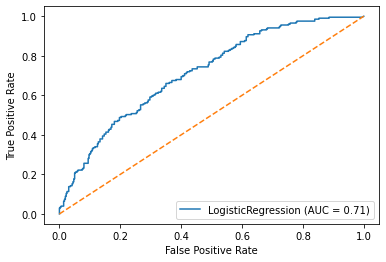

In [214]:
m.plot_roc_curve(LogitR, test_X, test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

In [ ]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, pred_y))

In [ ]:
confusion_matrix.to_csv("Confusion_Matrices/Morocco_DemPref_Logit.csv")

In [216]:
# train-test split
y = morocco.y_1_distrust_gov
X = morocco.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_distrust_gov"])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

In [217]:
clf = LogitR.fit(train_X, train_y)

In [218]:
pred_y= clf.predict(test_X)

In [219]:
m.roc_auc_score(test_y, pred_y)

0.6411871227364185

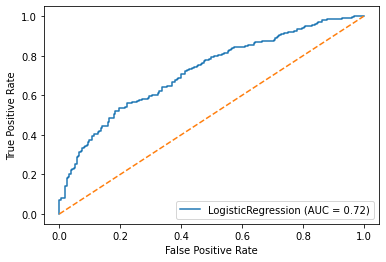

In [220]:
m.plot_roc_curve(LogitR, test_X, test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

In [ ]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, pred_y))

In [ ]:
confusion_matrix.to_csv("Confusion_Matrices/Morocco_TrustGov_Logit.csv")

In [221]:
# train-test split
y = egypt.y_2_dem_pref_not_in_dem
X = egypt.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_distrust_gov"])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

In [222]:
clf = LogitR.fit(train_X, train_y)

In [223]:
pred_y= clf.predict(test_X)

In [224]:
m.roc_auc_score(test_y, pred_y)

0.6913372582001682

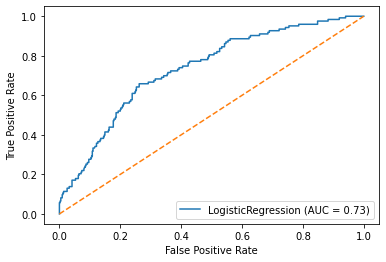

In [225]:
m.plot_roc_curve(LogitR, test_X, test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

In [ ]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, pred_y))

In [ ]:
confusion_matrix.to_csv("Confusion_Matrices/Egypt_DemPref_Logit.csv")

In [227]:
# train-test split
y = egypt.y_1_distrust_gov
X = egypt.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_distrust_gov"])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

In [228]:
clf = LogitR.fit(train_X, train_y)

In [229]:
pred_y= clf.predict(test_X)

In [230]:
m.roc_auc_score(test_y, pred_y)

0.6754342431761786

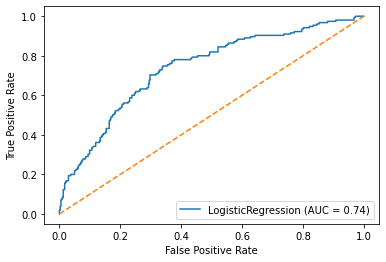

In [231]:
m.plot_roc_curve(LogitR, test_X, test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

In [ ]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, pred_y))

In [ ]:
confusion_matrix.to_csv("Confusion_Matrices/Egypt_TrustGov_Logit.csv")

In [232]:
# train-test split
y = algeria.y_2_dem_pref_not_in_dem
X = algeria.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_distrust_gov"])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

In [233]:
clf = LogitR.fit(train_X, train_y)

In [234]:
pred_y= clf.predict(test_X)

In [235]:
m.roc_auc_score(test_y, pred_y)

0.6240310838124766

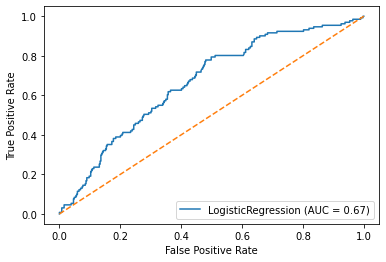

In [236]:
m.plot_roc_curve(LogitR, test_X, test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

In [ ]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, pred_y))

In [ ]:
confusion_matrix.to_csv("Confusion_Matrices/Algeria_DemPref_Logit.csv")